# 3. Test

In [1]:
import sys, os
import pandas as pd
sys.path.append("../../../../")

from Clust.setting import influx_setting_KETI as ins
from Clust.clust.ingestion.influx import influx_client_v2 as influx_Client
from Clust.clust.ingestion.mongo.mongo_client import MongoClient
db_client = influx_Client.InfluxClient(ins.CLUSTDataServer2)
mongo_client = MongoClient(ins.CLUSTMetaInfo2)

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [2]:
from Clust.clust.ML.common import ML_pipeline, tool

## 1. Data Preparation

In [3]:
app_name= "energy" # "Hs2SwineFarmWithWeatherTime", "energy"
model_method = 'GRU_rg'
model_clean = True
step = 'test'
bucket_name = 'integration'
data_clean_level=0

In [9]:
# model_name = None
# model_name = tool.get_default_model_name(model_name, app_name, model_method, model_clean)
model_name = 'regression_energy_cleanLevel4_trainX_regression_LSTM_rg_'
collection_name = 'meta'
db_name = 'model'
model_meta_list= mongo_client.get_document_by_json(db_name, collection_name,{'model_info.model_name':model_name} )
model_meta = model_meta_list[0] ## ??

In [10]:
model_meta

{'ingestion_param_X': {'bucket_name': 'integration',
  'ms_name': 'regression_energy_cleanLevel4_trainX',
  'feature_list': ['Press_mm_hg',
   'RH_1',
   'RH_2',
   'RH_3',
   'RH_4',
   'RH_5',
   'RH_6',
   'RH_7',
   'RH_8']},
 'ingestion_param_y': {'bucket_name': 'integration',
  'ms_name': 'regression_energy_cleanLevel4_trainy',
  'feature_list': ['value']},
 'data_y_flag': True,
 'scaler_param': {'scaler_flag': 'scale',
  'scale_method': 'minmax',
  'scaler_path': './scaler/',
  'scaler_file_path': {'XScalerFile': {'fileName': 'scaler.pkl',
    'filePath': './scaler/regression_energy_cleanLevel4_trainX/minmax/00db302f177c805568abc89cd77159bd/scaler.pkl'},
   'yScalerFile': {'fileName': 'scaler.pkl',
    'filePath': './scaler/regression_energy_cleanLevel4_trainy/minmax/f69156750a210491ffd4a67b605bc88b/scaler.pkl'}}},
 'transform_param': {'split_mode': 'window_split',
  'data_clean_option': False,
  'nan_process_info': {'type': 'num',
   'ConsecutiveNanLimit': 10000,
   'totalNaNLi

### 1-2. Data Ingestion
#### 1-2-1. X-y Data Ingestion pipeline

In [14]:
model_purpose = model_meta['model_info']['model_purpose']
dataset_name = model_purpose + '_' + app_name  
scaler_param= model_meta['scaler_param']['scaler_flag']
data_name_X = dataset_name + '_cleanLevel' + str(data_clean_level)+'_'+step+'X'
data_name_y = dataset_name+'_cleanLevel' + str(data_clean_level)+'_'+ step+'y'
data_y_flag = model_meta['data_y_flag']

In [15]:
feature_X_list = model_meta['ingestion_param_X']['feature_list']
feature_y_list = model_meta['ingestion_param_y']["feature_list"]
model_file_path = model_meta['model_info']['model_file_path']['modelFile']["filePath"]

In [17]:
# Data Ingestion
ingestion_method = 'ms_all'
ingestion_param_X = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_X,
    'feature_list' : feature_X_list                              
}
ingestion_param_y = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_y,
    'feature_list' : feature_y_list                              
}

In [18]:
def get_scaled_data(data, scaler, scaler_param):

    if scaler_param=='scale':
        scaled_data = pd.DataFrame(scaler.transform(data), index = data.index, columns = data.columns)
    else:
        scaled_data = data.copy()
    return scaled_data

In [19]:
def scaler_file_load_to_server(scaler_path):
    import paramiko
    import pickle

    # Scaler 객체를 저장할 파일 경로
    remote_scaler_path = '/programdrive/Clust/file_save_test'
    scaler_server_path = remote_scaler_path + scaler_path[1:]
    scaler_local_path = os.getcwd() + scaler_path[1:]
    scaler_folder_path = scaler_server_path[:-10]

    # SSH 연결 설정
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect('10.252.107.59', username='jhlee', password='dlwlgns1')

    # Scaler 파일 전송
    sftp = ssh.open_sftp()
    sftp.get(scaler_local_path ,scaler_path)
    sftp.close()

    # SSH 연결 종료
    ssh.close()

In [20]:
def get_scaler_file(scaler_file_path):

    import joblib
    scaler_file_load_to_server(scaler_file_path)
    scaler = joblib.load(scaler_file_path)
    return scaler

In [21]:
def get_scaled_test_data(data, scaler_file_path, scaler_param):
    scaler =None
    result = data
    if scaler_param =='scale':
        if scaler_file_path:
            scaler = get_scaler_file(scaler_file_path)
            result = get_scaled_data(data, scaler, scaler_param)
    return result, scaler

In [22]:
def Xy_data_scaling_test(data_X, data_y, X_scaler_file_path, y_scaler_file_path, scaler_param):

    test_X, scaler_X = ml_scaler.get_scaled_test_data(data_X, X_scaler_file_path, scaler_param)
    test_y, scaler_y = ml_scaler.get_scaled_test_data(data_y, y_scaler_file_path, scaler_param)
    return test_X, scaler_X , test_y, scaler_y 

In [23]:
data_X, data_y = ML_pipeline.Xy_data_preparation(ingestion_param_X, data_y_flag, ingestion_param_y, ingestion_method, db_client)

{'bucket_name': 'integration', 'ms_name': 'regression_energy_cleanLevel0_testX', 'feature_list': ['Press_mm_hg', 'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8']}


#### 1-2-2. Random Nan Insert (Test)
#### 1-2-3. Data scaling

In [26]:
X_scaler_file_path = model_meta['scaler_param']['scaler_file_path']['XScalerFile']["filePath"]
y_scaler_file_path = model_meta['scaler_param']['scaler_file_path']['yScalerFile']["filePath"]
y_scaler_file_path

'./scaler/regression_energy_cleanLevel4_trainy/minmax/f69156750a210491ffd4a67b605bc88b/scaler.pkl'

In [28]:
# scaler_param = model_meta["scalerParam"]
test_X, scaler_X , test_y, scaler_y  = ML_pipeline.Xy_data_scaling_test(data_X, data_y, X_scaler_file_path, y_scaler_file_path, scaler_param)

FileNotFoundError: [Errno 2] No such file or directory: './scaler/regression_energy_cleanLevel4_trainX/minmax/00db302f177c805568abc89cd77159bd/scaler.pkl'

#### 1-2-2. Random Nan Insert (Test X)
#### 1-2-3. Data scaling

In [47]:
split_mode = model_meta['dataSplitMode']
transformParameter = model_meta["transformParameter"]
test_X_array, test_y_array = ML_pipeline.transform_data_by_split_mode(split_mode, transformParameter, test_X, test_y)

window_size: 144 nan_limit_num: 72
(6048, 24) (42, 144, 24)
(42, 1) (42, 1)


In [48]:
modelParameter = model_meta["modelParameter"]

testParameter = {
    'device': 'cpu',
    'batch_size': model_meta["trainParameter"]['batch_size']
}

In [49]:
#3. Test model
preds, trues = ML_pipeline.CLUST_regresstion_test(test_X_array, test_y_array, testParameter, model_method, model_file_path, modelParameter)

features shape: torch.Size([42, 144, 24]) targets shape:  torch.Size([42, 1])

Start testing data



In [50]:
print(test_X_array.shape, test_y_array.shape)
print(preds.shape, trues.shape)
target = feature_y_list[0]
scaler, feature_list = ML_pipeline.get_scaler_information_by_y_flag(data_y_flag, scaler_X, scaler_y, feature_X_list, feature_y_list)
df_result, result_metrics = ML_pipeline.get_final_metrics(preds, trues, scaler_param, scaler, feature_list, target)

(42, 144, 24) (42, 1)
(32,) (32,)
scale


        value  prediction
0   17.370001   13.915736
1   20.650000   13.738004
2   11.420000   13.792073
3   10.680000   14.561427
4   12.439999   14.089519
5   11.170000   13.869466
6   24.120001   15.998723
7   10.990000   13.373091
8   13.760000   15.189082
9   14.560000   15.560471
10  14.970000   14.985352
11  13.429999   15.059691
12  11.570000   14.288507
13   9.330000   16.243668
14  15.580000   15.514131
15  20.929998   14.449985
16  11.990000   13.331085
17  15.370000   14.386933
18  10.470000   14.940999
19  14.410000   14.720536
20  10.160000   13.422237
21  15.120000   14.217023
22  12.320000   14.223423
23  10.460000   14.422492
24  15.060000   12.609772
25   9.680000   15.253193
26  10.690000   13.681235
27  17.799997   16.160351
28  10.690000   14.976705
29  17.059998   14.148298
30  20.879999   17.509621
31  10.890000   13.608142
{'mae': 2.9626193, 'rmse': 3.5919190096146183, 'r2': 0.07706300579909708, 'mape': 22.65273779630661}


<Axes: >

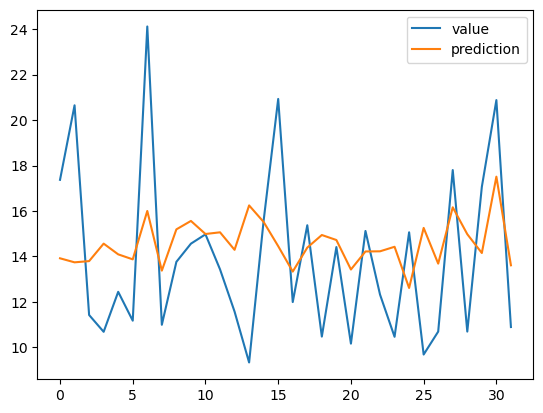

In [51]:
print(df_result)
print(result_metrics)
df_result.plot()

In [30]:
# 5. Only For IPython Notebook
#from Clust.clust.tool.plot.plot_two_data import plot_predictions
#import plotly.offline as pyo
# Set notebook mode to work in offline
#pyo.init_notebook_mode()
#plot_predictions(df_result)